In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Core python modules
import sys, os
import dill
from functools import partial

# Data processing
import pandas as pd
import numpy as np
import scipy

# Networks
import networkx as nx

# Modules
sys.path.insert(0, '../scripts')
from evaluation import Data
from samplers import *
from gsd import GSD
from benchmarks import *

In [3]:
# Plotting
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

## STRING import

In [4]:
edgelist = pd.read_csv('../data/interactomes/string.v10.5.cleaned.namespace-mapped.exp.tsv', sep='\t')
edgelist = edgelist[edgelist['protein1'] != edgelist['protein2']]
edgelist['cost'] = 1 / edgelist['confidence']
edgelist.head()

,protein1,protein2,confidence,cost
0,A1BG,CRISP3,0.457,2.188184
1,A1CF,CAVIN2,0.280,3.571429
2,A2M,ADAM19,0.382,2.617801
3,A2M,ADAMTS1,0.415,2.409639
4,A2M,ADAMTS12,0.315,3.174603


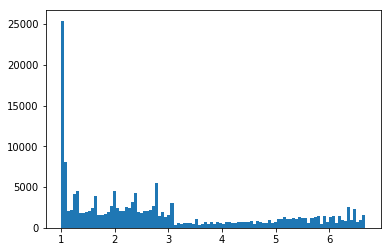

In [5]:
plt.hist(edgelist['cost'], bins=100);

In [6]:
G = nx.from_pandas_edgelist(edgelist, source='protein1', target='protein2', edge_attr=['confidence', 'cost'])
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 15077
Number of edges: 176203
Average degree:  23.3737


## Edge penalty

In [7]:
def get_edge_penalty(graph):
    
    N = len(graph.nodes)
    degrees = dict(graph.degree(weight='cost'))
    edge_penalties = np.array([degrees[a]*degrees[b] / ((N-degrees[a]-1) * (N-degrees[b]-1) + degrees[a]*degrees[b]) for a,b in graph.edges])
    
    return edge_penalties

def edge_costs(graph, g):
    
    cost = np.array([ cost for _,_,cost in graph.edges.data('cost') ])
    cost_new = cost + get_edge_penalty(graph) * (10**g)
    
    return cost_new

In [8]:
adjusted_cost = edge_costs(G, 4)

G_adj = G.copy()
nx.set_edge_attributes(G_adj, adjusted_cost, 'cost')

nx.write_gpickle(G_adj, '../data/interactomes/STRING_v10.5.experimental.costs_adj_g4.gpickle')